In [1]:
import re
import pandas as pd
from multiprocess import Pool
from functools import partial
import multiprocess as mp
import matplotlib.pyplot as plt

In [101]:
keywords = [
    "made in america", "made in u.s.", "made in us", # made in usa and made in us overlap
    "american made", "usa made", "u.s. made", "us made"
    "buy american", "buy usa", "buy america",
    "support america", "support usa", "support u.s.",
    "patriot",
    "choose american", "choose usa", "choose u.s.", "choose america",
    "national pride",
    "usa based", "america based", "american based", "us based", "u.s. based",
    "usa produced", "america produced", "american produced", "us produced", "u.s. produced",
    "usa manufactured", "america manufactured", "american manufactured", "us manufactured", "u.s. manufactured",
    "american worker", "american job",
    "veteran owned", "veteran founded", "founded by veteran",
    "handcrafted in america", "handcrafted in usa", "handcrafted in u.s.", "handcrafted in us",
    "crafted in america", "crafted in u.s.", "crafted in us", # removed "crafted in the usa" due to overlap with crafted in the US
    "america heritage", "america tradition", "america value",
    "icon of america", "icon of usa", "icon of u.s.",
    "america manufactur", "u.s. manufactur"
]


In [120]:
# df = pd.read_csv("buy_usa_second_round_with_additional_firms.csv")
# df = pd.read_csv("about_us_second_round_with_additional_firms.csv")
df = pd.read_csv("company_website_second_round_with_additional_firms.csv")

def filter_columns(df):
    pattern = r"^\d{4}-\d{2}$"  # Regex to match the YYYY-MM format
    # Keep 'std_name' and any other column that matches the date format
    filtered_columns = ['std_name'] + [col for col in df.columns if re.match(pattern, col)]
    return df[filtered_columns]

df = filter_columns(df)
df = df.drop_duplicates(subset='std_name', keep='first').reset_index(drop=True)
df = df.sort_values(by='std_name').reset_index(drop=True)
df = df.drop(columns=['std_name'])
columns = list(df.columns)

C:\Users\theal\AppData\Local\Temp\ipykernel_72380\1358610452.py:3: DtypeWarning: Columns (300,304,325,328) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("company_website_second_round_with_additional_firms.csv")


In [121]:
df.sample(50)

,2023-10,2023-09,2023-08,2023-07,2023-06,2023-05,2023-04,2023-03,2023-02,2023-01,...,1997-07,1997-06,1997-05,1997-04,1997-03,1997-02,1997-01,1996-12,1996-11,1996-10
1639,\nFleetwood RV | 2024 Class A Motor Coaches & ...,\nFleetwood RV | 2024 Class A Motor Coaches & ...,\nFleetwood RV | 2024 Class A Motor Coaches & ...,\nFleetwood RV | 2023 Class A Motor Coaches & ...,\nFleetwood RV | 2023 Class A Motor Coaches & ...,\nFleetwood RV | 2023 Class A Motor Coaches & ...,\nFleetwood RV | 2023 Class A Motor Coaches & ...,NaN,\nFleetwood RV | 2023 Class A Motor Coaches & ...,\nFleetwood RV | 2023 Class A Motor Coaches & ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2193,\nHuggy Bear – Quality Cabinets Made in Oregon...,NaN,NaN,NaN,\nHuggy Bear – Quality Cabinets Made in Oregon...,\nHuggy Bear – Quality Cabinets Made in Oregon...,"\nOne moment, please...\nPlease wait while you...","\nOne moment, please...\nPlease wait while you...",NaN,\nHuggy Bear – Quality Cabinets Made in Oregon...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"\nWelcome to SpiritOne!\nWelcome to SpiritOne,...",NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4357,NaN,\nSolar Panel Riverside - SunSpark Technology ...,NaN,NaN,\nSolar Panel Riverside - SunSpark Technology ...,\nSolar Panel Riverside - SunSpark Technology ...,NaN,NaN,\nHome Page - SunSpark Technology Inc\nFollowF...,\nHome Page - SunSpark Technology Inc\nFollowF...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1646,FlightWave Aerospace Systems Navig...,FlightWave Aerospace Systems Navig...,NaN,NaN,FlightWave Aerospace Systems Navig...,NaN,NaN,FlightWave Aerospace Systems Navi...,FlightWave Aerospace Systems Navi...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5140,"Yokohama Tire | Find New Tires for Cars, SUVs ...","Yokohama Tire | Find New Tires for Cars, SUVs ...","Yokohama Tire | Find New Tires for Cars, SUVs ...","Yokohama Tire | Find New Tires for Cars, SUVs ...","Yokohama Tire | Find New Tires for Cars, SUVs ...",NaN,"Yokohama Tire | Find New Tires for Cars, SUVs ...",NaN,"Yokohama Tire | Find New Tires for Cars, SUVs ...","Yokohama Tire | Find New Tires for Cars, SUVs ...",...,NaN,NaN,NaN,Index of /\nIndex of /\n Name ...,NaN,NaN,NaN,\nYokohama Tires - Main Page\nWelcome to Yokoh...,NaN,NaN
4075,NaN,NaN,NaN,\nHome - Simply Natural Creamery\n Where to Bu...,\nHome - Simply Natural Creamery\n Where to Bu...,\nHome - Simply Natural Creamery\n Where to Bu...,NaN,\nHome - Simply Natural Creamery\n Where to Bu...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2269,NaN,Power Equipment Distributor @ Great Northern E...,NaN,Power Equipment Distributor @ Great Northern E...,Power Equipment Distributor @ Great Northern E...,"\nGreat Northern Equipment Distributing, Inc. ...",NaN,Power Equipment Distributor @ Great Northern E...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2544,\nHomepage - Kreider Farms\n Cart (0 ITEMS)\...,NaN,NaN,NaN,\nHomepage - Kreider Farms\n Cart (0 ITEMS)\...,\nHomepage - Kreider Farms\n Cart (0 ITEMS)\...,\nHomepage - Kreider Farms\n Cart (0 ITEMS)\...,\nHomepage - Kreider Farms\n Cart (0 ITEMS)\...,\nHomepage - Kreider Farms\n Cart (0 ITEMS)\...,\nHomepage - Kreider Farms\n Cart (0 ITEMS)\...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
def count_keywords_in_cell(cell, keywords):
    return sum(1 if keyword.lower() in str(cell).lower() else 0 for keyword in keywords)

def calculate_total_counts(df, columns, keywords):
    total_counts_df = pd.DataFrame(index=df.index, columns=columns, dtype=int).fillna(0)

    for index, row in df.iterrows():
        previous_count = 0  # Initialize the previous count
        for col_idx, col in enumerate(reversed(columns)):
            cell_value = row[col]
            current_count = count_keywords_in_cell(cell_value, keywords)

            # If the current count is zero and the previous count is greater than zero, use the previous count
            if current_count < previous_count:
                total_counts_df.at[index, columns[len(columns) - 1 - col_idx]] = previous_count
            else:
                total_counts_df.at[index, columns[len(columns) - 1 - col_idx]] = current_count
                previous_count = current_count  # Update previous count

    return total_counts_df

In [123]:
total_counts_df = calculate_total_counts(df, columns, keywords)

In [124]:
document_counts = [0] * len(columns) # Initialize a list to hold the count of documents for each year.

for row in df.itertuples(index=False):# Iterate over each row in the DataFrame.
    previous_count = 0 # Initialize the previous count to 0 for the first iteration.

    for idx in reversed(range(len(columns))):    # Iterate over the columns in reverse order to update the document count.
        value = row[idx] # Access the value using the appropriate index for itertuples() output.

        # Check if the current cell has a document (non-NaN and not an empty string).
        if pd.isna(value) or isinstance(value, int):
            document_counts[idx] += previous_count # If there's a document, increment the count for the year and set the previous count to 1.
        else:
            document_counts[idx] += 1 # If there's no document, add the previous year's count to this year's count.
            previous_count = 1 # We have found a document so previous should never be 0



total_documents = sum(document_counts)
document_count_sum = total_documents
# Print the total number of documents.
print(total_documents)

# This number is less than other because the index column was included in previous calculations

878379


In [125]:
def count_term_existence(df, columns, total_counts_df, keyword):
    import pandas as pd
    print(f"Processing keyword: {keyword}")
    term_existence = [0] * len(columns)

    for index, row in df.iterrows():
        previous_total_count = 0  # Initialize the total count for all keywords in the previous cell
        for col_idx, col in enumerate(reversed(columns)):
            cell_value = row[col]
            current_total_count = total_counts_df.at[index, col]

            if current_total_count < previous_total_count:
            # if current_total_count == 0 and previous_total_count > 0:
                # If total count drops to 0 but was higher before, carry over the previous value
                term_existence[len(columns) - 1 - col_idx] += 1
            elif pd.isna(cell_value) or isinstance(cell_value, int):
                term_existence[len(columns) - 1 - col_idx] += 0
            else:
                if keyword in cell_value.lower():
                    term_existence[len(columns) - 1 - col_idx] += 1
                else:
                    term_existence[len(columns) - 1 - col_idx] += 0

            if current_total_count < previous_total_count:
            # if current_total_count == 0 and previous_total_count > 0:
                previous_total_count = previous_total_count
            else:
                previous_total_count = current_total_count  # Update the total count for the next iteration

    return {keyword: sum(term_existence)}

In [126]:
count_term_existence(df, columns, total_counts_df, 'made in america')

Processing keyword: made in america


{'made in america': 14578}

In [127]:
func = partial(count_term_existence, df, columns, total_counts_df)

# Initialize multiprocessing Pool
with Pool(processes=4) as pool:
    # Map the function across the keywords
    results = pool.map(func, keywords)

# Combine the results
term_count = {}
for result in results:
    term_count.update(result)

print(term_count)

{'made in america': 14578, 'made in u.s.': 2283, 'made in us': 22400, 'american made': 20574, 'usa made': 7013, 'u.s. made': 715, 'us madebuy american': 0, 'buy usa': 341, 'buy america': 1562, 'support america': 674, 'support usa': 229, 'support u.s.': 20, 'patriot': 7077, 'choose american': 95, 'choose usa': 68, 'choose u.s.': 13, 'choose america': 95, 'national pride': 25, 'usa based': 233, 'america based': 31, 'american based': 25, 'us based': 287, 'u.s. based': 446, 'usa produced': 28, 'america produced': 0, 'american produced': 0, 'us produced': 0, 'u.s. produced': 1, 'usa manufactured': 499, 'america manufactured': 0, 'american manufactured': 37, 'us manufactured': 52, 'u.s. manufactured': 11, 'american worker': 1401, 'american job': 752, 'veteran owned': 1166, 'veteran founded': 31, 'founded by veteran': 4, 'handcrafted in america': 517, 'handcrafted in usa': 324, 'handcrafted in u.s.': 32, 'handcrafted in us': 324, 'crafted in america': 967, 'crafted in u.s.': 53, 'crafted in u

In [128]:
                # keyword_count = row[column].lower().count(keyword) # This is the term frequency within this document
                # value = (keyword_count * idf / len(row[column]))*100 # This is the formula

                # keyword_count = row[column].lower().count(keyword) # This is the term frequency within this document (for not using TF-IDF)
                # value = keyword_count # No changes to the value here! (for not using TF-IDF)

                # idf = math.log(1 + (document_count_sum/term_existence)) # This is the IDF formula
                # keyword_count = row[column].lower().count(keyword) # This is the term frequency within this document
                # value = (keyword_count * idf / len(row[column]))*100 # This is the formula

                # keyword_count = row[column].lower().count(keyword) # This is the term frequency within this document (for not using TF-IDF)
                # value = keyword_count # No changes to the value here! (for not using TF-IDF)

In [129]:
def generate_final_value_by_year(df, total_counts_df, columns, document_count_sum, data):
    import math
    import pandas as pd  # Ensure pandas is imported in the function's scope

    def count_keyword_in_cell(cell, keyword):
        return 1 if keyword.lower() in str(cell).lower() else 0

    def count_total_keywords(cell, keywords):
        return sum(count_keyword_in_cell(cell, kw) for kw in keywords)
    keyword, term_existence = data

    print("Processing keyword: ", keyword)
    term_existence_full = [0] * len(columns)

    if term_existence == 0: # Skip over if this term wasn't counted in any of the years
        return {keyword: term_existence_full}

    for index, row in df.iterrows():
        previous_value = 0
        previous_total_count = 0
        for col_idx, col in enumerate(reversed(columns)):
            cell_value = row[col]
            current_total_count = total_counts_df.at[index, col]

            if current_total_count < previous_total_count:

            # if current_total_count == 0 and previous_total_count > 0:
                # If total count drops to 0 but was higher before, carry over the previous value
                term_existence_full[len(columns) - 1 - col_idx] += previous_value
            elif pd.isna(cell_value) or isinstance(cell_value, int):
                term_existence_full[len(columns) - 1 - col_idx] += 0
                previous_value = 0
            else:
                # if keyword in cell_value.lower():
                #     term_existence[len(columns) - 1 - col_idx] += 1
                # else:
                #     term_existence[len(columns) - 1 - col_idx] += 0


                # idf = math.log(1 + (document_count_sum/term_existence)) # This is the IDF formula
                # keyword_count = row[col].lower().count(keyword) # This is the term frequency within this document
                # value = (keyword_count * idf / len(row[col]))*100 # This is the formula

                keyword_count = row[col].lower().count(keyword) # This is the term frequency within this document (for not using TF-IDF)
                value = keyword_count # No changes to the value here! (for not using TF-IDF)

                term_existence_full[len(columns) - 1 - col_idx] += value
                previous_value = value
                
            if current_total_count < previous_total_count:
            # if current_total_count == 0 and previous_total_count > 0:
                previous_total_count = previous_total_count
            else:
                previous_total_count = current_total_count  # Update the total count for the next iteration


    return {keyword: term_existence_full}

In [130]:
# Run this over all of the different keywords

func = partial(generate_final_value_by_year, df, total_counts_df, columns, document_count_sum)

# Use multiprocessing to map the keywords to the function
pool = mp.Pool(processes=6)
results = pool.map(func, ((keyword, term_count[keyword]) for keyword in keywords))

# Combine the results
tf_idf_total = {}
for result in results:
    tf_idf_total.update(result)

In [131]:
year_sums = [0] * len(columns)
for keyword in keywords: # Going through all of the keywords
    if type(tf_idf_total[keyword]) == int: # This is a redundant invalid check
        continue
    for column in range(len(columns)): # Go through all of the years
        year_sums[column] += tf_idf_total[keyword][column] # Adding up all the sums per year

for column in range(len(columns)):
    # print(document_count[column])
    try:
        year_sums[column] /= document_counts[column]
        # year_sums[column] /= 1
    except:
        try:
            year_sums[column] /= document_counts[column+1]
            # year_sums[column] /= 1
        except:
            year_sums[column] /= 1
print(year_sums[:10])

[0.366412213740458, 0.2549661645928836, 0.27850589777195284, 0.2799650043744532, 0.5474628171478565, 0.4131815195971097, 0.33238324928743695, 0.5005488474204172, 0.37687224669603525, 0.39448732083792726]


325 DatetimeIndex(['2023-10-01', '2023-09-01', '2023-08-01'], dtype='datetime64[ns]', freq=None)


C:\Users\theal\AppData\Local\Temp\ipykernel_72380\3033080287.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  columns_plot = pd.to_datetime(df.columns, errors='coerce', infer_datetime_format=True)


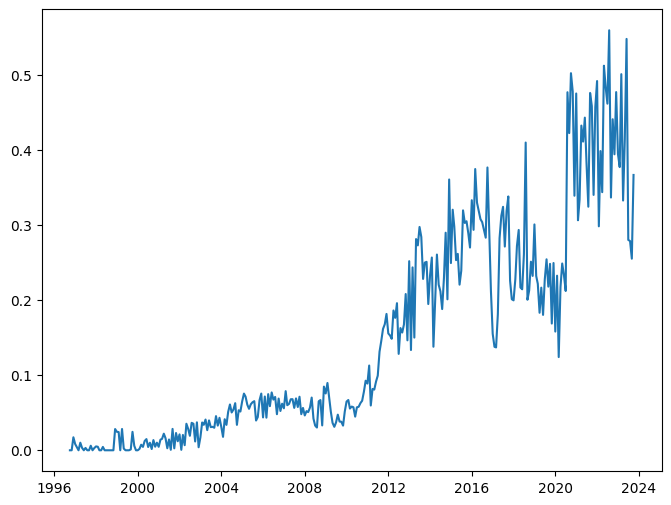

In [132]:
columns_plot = pd.to_datetime(df.columns, errors='coerce', infer_datetime_format=True)
columns_plot = columns_plot.dropna()

# Ensure year_sums has the same length as columns after filtering NaT
# Adjust year_sums accordingly if necessary

print(len(columns_plot), columns_plot[:3])

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(columns_plot, list(year_sums))  # Plotting it!

plt.show()  # Display the plot

In [90]:
year_sums_buy_usa_tfidf = year_sums

In [91]:
year_sums_buy_usa_no_tfidf = year_sums

In [46]:
year_sums_about_us_no_tfidf = year_sums

In [51]:
year_sums_about_us_tfidf = year_sums

In [92]:
year_sums_company_website_information_tfidf = year_sums # RAN TODAY

In [85]:
year_sums_company_website_information_no_tfidf = year_sums # RAN TODAY

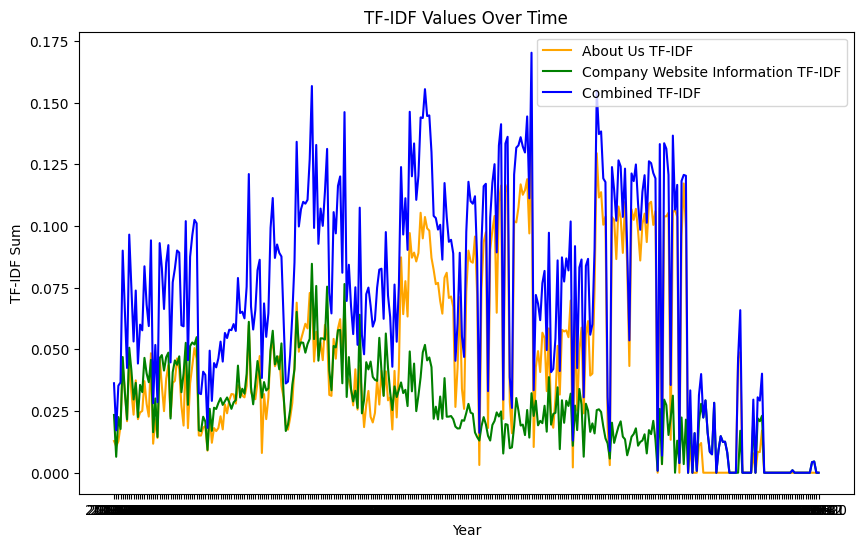

In [53]:
# Update the combined TF-IDF calculation to include "Buy USA"
combined_tfidf = [sum(x) for x in zip(year_sums_about_us_tfidf, year_sums_company_website_information_tfidf)]

# Plot the TF-IDF values including "Buy USA"
plt.figure(figsize=(10, 6))
plt.plot(columns, year_sums_about_us_tfidf, label='About Us TF-IDF', linestyle='-', color='orange')
plt.plot(columns, year_sums_company_website_information_tfidf, label='Company Website Information TF-IDF', linestyle='-', color='green')
plt.plot(columns, combined_tfidf, label='Combined TF-IDF', linestyle='-', color='blue')
plt.legend()
plt.title('TF-IDF Values Over Time')
plt.xlabel('Year')
plt.ylabel('TF-IDF Sum')
plt.show()


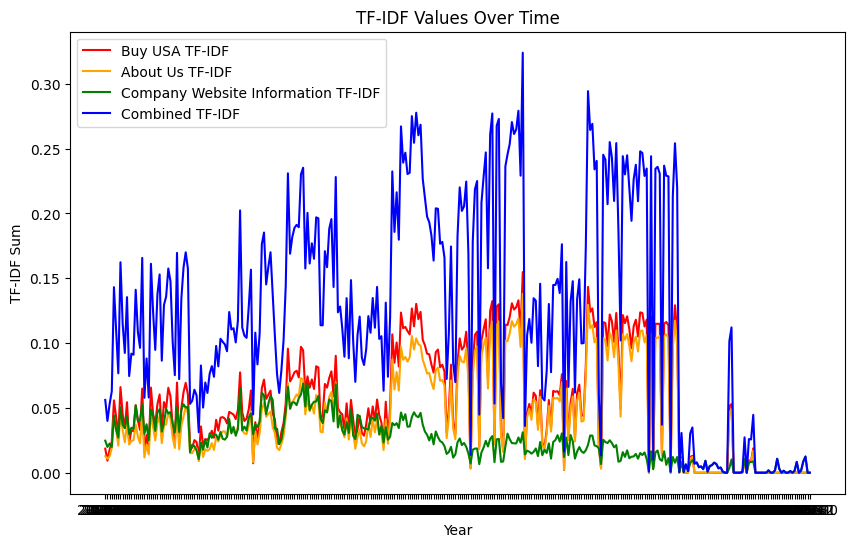

In [ ]:
# Update the combined TF-IDF calculation to include "Buy USA"
combined_tfidf = [sum(x) for x in zip(year_sums_buy_usa_tfidf, year_sums_about_us_tfidf, year_sums_company_website_information_tfidf)]

# Plot the TF-IDF values including "Buy USA"
plt.figure(figsize=(10, 6))
plt.plot(columns, year_sums_buy_usa_tfidf, label='Buy USA TF-IDF', linestyle='-', color='red')
plt.plot(columns, year_sums_about_us_tfidf, label='About Us TF-IDF', linestyle='-', color='orange')
plt.plot(columns, year_sums_company_website_information_tfidf, label='Company Website Information TF-IDF', linestyle='-', color='green')
plt.plot(columns, combined_tfidf, label='Combined TF-IDF', linestyle='-', color='blue')
plt.legend()
plt.title('TF-IDF Values Over Time')
plt.xlabel('Year')
plt.ylabel('TF-IDF Sum')
plt.show()


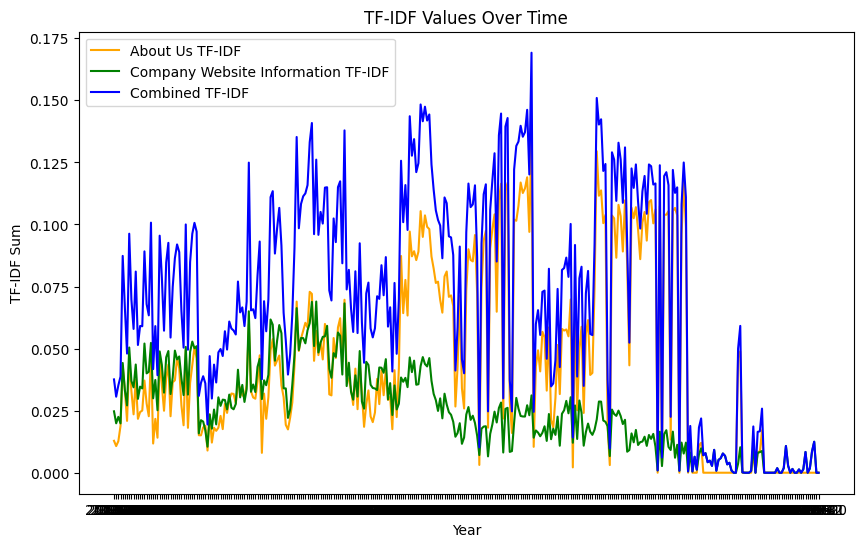

In [ ]:
# Update the combined TF-IDF calculation to include all available data
combined_tfidf = [sum(x) for x in zip(year_sums_about_us_tfidf, year_sums_company_website_information_tfidf)]

# Plot the TF-IDF values
plt.figure(figsize=(10, 6))
plt.plot(columns, year_sums_about_us_tfidf, label='About Us TF-IDF', linestyle='-', color='orange')
plt.plot(columns, year_sums_company_website_information_tfidf, label='Company Website Information TF-IDF', linestyle='-', color='green')
plt.plot(columns, combined_tfidf, label='Combined TF-IDF', linestyle='-', color='blue')
plt.legend()
plt.title('TF-IDF Values Over Time')
plt.xlabel('Year')
plt.ylabel('TF-IDF Sum')
plt.show()


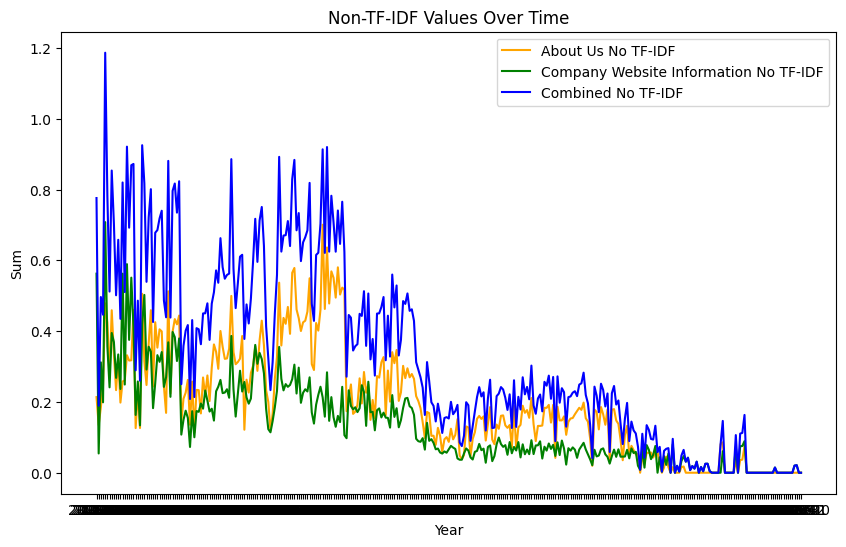

In [54]:
# Update the combined non-TF-IDF calculation to include all available data
combined_no_tfidf = [sum(x) for x in zip(year_sums_about_us_no_tfidf, year_sums_company_website_information_no_tfidf)]

# Plot the non-TF-IDF values, including the 'Buy USA No TF-IDF' series
plt.figure(figsize=(10, 6))
plt.plot(columns, year_sums_about_us_no_tfidf, label='About Us No TF-IDF', linestyle='-', color='orange')
plt.plot(columns, year_sums_company_website_information_no_tfidf, label='Company Website Information No TF-IDF', linestyle='-', color='green')
plt.plot(columns, combined_no_tfidf, label='Combined No TF-IDF', linestyle='-', color='blue')
plt.legend()
plt.title('Non-TF-IDF Values Over Time')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.show()


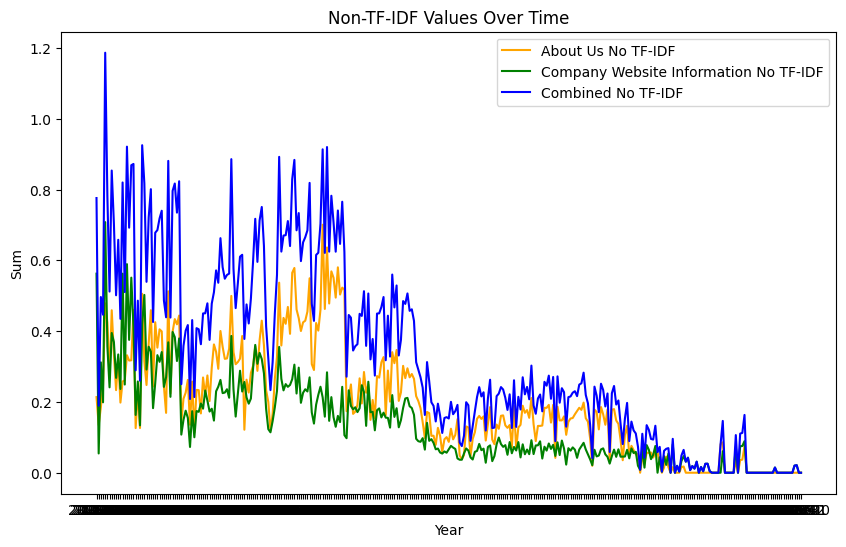

In [93]:
# Update the combined non-TF-IDF calculation to include all available data
combined_no_tfidf = [sum(x) for x in zip(year_sums_about_us_no_tfidf, year_sums_company_website_information_no_tfidf)]

# Plot the non-TF-IDF values, including the 'Buy USA No TF-IDF' series
plt.figure(figsize=(10, 6))
plt.plot(columns, year_sums_about_us_no_tfidf, label='About Us No TF-IDF', linestyle='-', color='orange')
plt.plot(columns, year_sums_company_website_information_no_tfidf, label='Company Website Information No TF-IDF', linestyle='-', color='green')
plt.plot(columns, combined_no_tfidf, label='Combined No TF-IDF', linestyle='-', color='blue')
plt.legend()
plt.title('Non-TF-IDF Values Over Time')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.show()


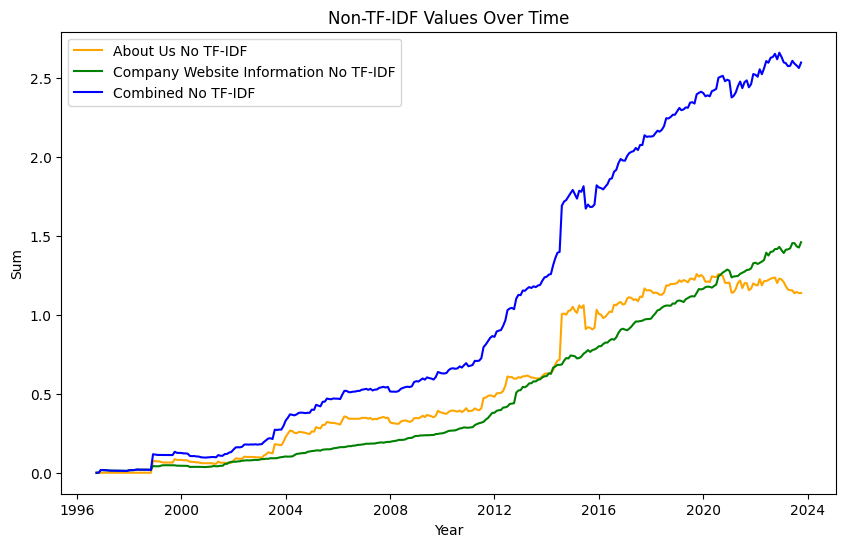

In [ ]:
columns_trimmed = columns[-min_length_no_tfidf:]

combined_no_tfidf = [sum(x) for x in zip(year_sums_buy_usa_no_tfidf_trimmed, year_sums_about_us_no_tfidf_trimmed, year_sums_company_website_information_no_tfidf_trimmed)]

# Plot the non-TF-IDF values, including the 'Buy USA No TF-IDF' seriesc:\Users\theal\PycharmProjects\miu-phrases\sp_2024\plot-recreation-11-7-2024\countcsvalex.py
plt.figure(figsize=(10, 6))
plt.plot(columns_trimmed, year_sums_buy_usa_no_tfidf_trimmed, label='Buy USA No TF-IDF', linestyle='-', color='red')
plt.plot(columns_trimmed, year_sums_about_us_no_tfidf_trimmed, label='About Us No TF-IDF', linestyle='-', color='orange')
plt.plot(columns_trimmed, year_sums_company_website_information_no_tfidf_trimmed, label='Company Website Information No TF-IDF', linestyle='-', color='green')
plt.plot(columns_trimmed, combined_no_tfidf, label='Combined No TF-IDF', linestyle='-', color='blue')
plt.legend()
plt.title('Non-TF-IDF Values Over Time')
plt.xlabel('Year')
plt.ylabel('Sum')
plt.show()

In [94]:
year_sums_company_website_information_no_tfidf

[0.562358276643991,
 0.05442176870748299,
 0.31179138321995464,
 0.19886363636363635,
 0.7079545454545455,
 0.3568181818181818,
 0.24118316268486917,
 0.39476678043230945,
 0.3690205011389522,
 0.26795895096921324,
 0.33409350057012543,
 0.23657142857142857,
 0.5622857142857143,
 0.24914285714285714,
 0.5892448512585813,
 0.37528604118993136,
 0.5510907003444316,
 0.4121699196326062,
 0.1632183908045977,
 0.25776754890678943,
 0.13379469434832755,
 0.41965317919075146,
 0.5023148148148148,
 0.29152148664343785,
 0.3559718969555035,
 0.3419506462984724,
 0.18235294117647058,
 0.2529411764705882,
 0.3321554770318021,
 0.3132387706855792,
 0.3408284023668639,
 0.24256837098692033,
 0.27001194743130225,
 0.3684210526315789,
 0.21437125748502994,
 0.3976047904191617,
 0.38313253012048193,
 0.31559854897218864,
 0.3793939393939394,
 0.10771113831089352,
 0.14932680538555693,
 0.17524509803921567,
 0.15498154981549817,
 0.07274969173859433,
 0.17385943279901356,
 0.10012360939431397,
 0.17428

In [ ]:
year_sums_company_website_information_no_tfidf_trimmed

[1.458669574700109,
 1.4250163719711852,
 1.432503276539974,
 1.452755905511811,
 1.452755905511811,
 1.4199693453032625,
 1.4135058101293576,
 1.4111964873765093,
 1.3905286343612335,
 1.4083792723263506,
 1.429013027158313,
 1.4157999557424208,
 1.4155412884657959,
 1.3994685562444642,
 1.3980496453900708,
 1.3745285112047925,
 1.392357253943568,
 1.3463761671854158,
 1.3359305431878896,
 1.3277591973244147,
 1.3210538066532709,
 1.3290149653786016,
 1.325206888839186,
 1.29337822671156,
 1.2844284428442845,
 1.2829763246899661,
 1.2726039783001808,
 1.2654307031426633,
 1.2588315217391304,
 1.2453472537448933,
 1.243347737093473,
 1.2416229769774334,
 1.2361682670324645,
 1.2783882783882783,
 1.2855833142333257,
 1.2755219086946548,
 1.2668357933579335,
 1.25387641749595,
 1.242671009771987,
 1.191238813000471,
 1.1812603257021477,
 1.1714015151515151,
 1.1762889047279639,
 1.1776190476190476,
 1.1744518589132507,
 1.1637231503579952,
 1.1597039866316543,
 1.1624401913875597,
 1.137

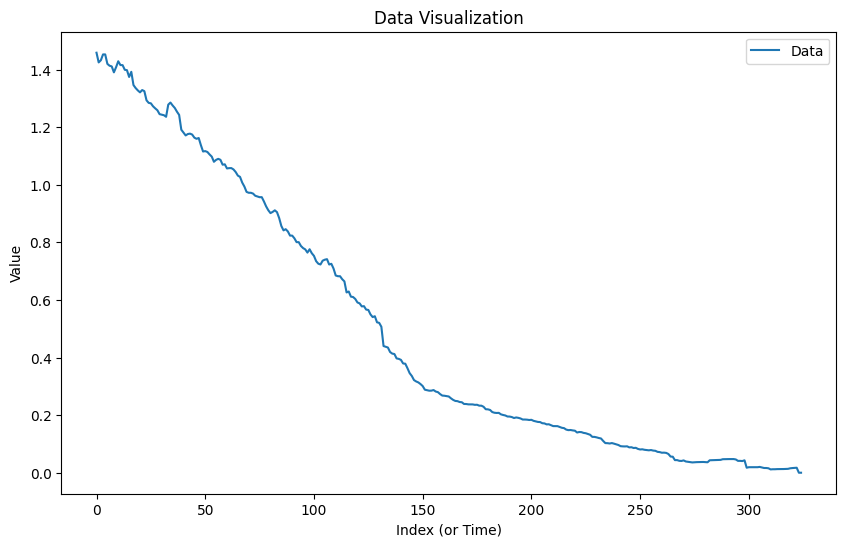

In [ ]:
columns = range(len(year_sums_company_website_information_no_tfidf_trimmed))

plt.figure(figsize=(10, 6))
plt.plot(columns, year_sums_company_website_information_no_tfidf_trimmed, linestyle='-', label='Data')  # Ensure lines are connected
plt.title('Data Visualization')
plt.xlabel('Index (or Time)')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Assuming year_sums_* variables are defined in the user's environment,
# we will save each one to a text file.

# Saving year_sums_buy_usa_tfidf to a text file
with open('/mnt/data/year_sums_buy_usa_tfidf.txt', 'w') as file:
    file.writelines(f"{value}\n" for value in year_sums_buy_usa_tfidf)

# Saving year_sums_buy_usa_no_tfidf to a text file
with open('/mnt/data/year_sums_buy_usa_no_tfidf.txt', 'w') as file:
    file.writelines(f"{value}\n" for value in year_sums_buy_usa_no_tfidf)

# Saving year_sums_about_us_tfidf to a text file
with open('/mnt/data/year_sums_about_us_tfidf.txt', 'w') as file:
    file.writelines(f"{value}\n" for value in year_sums_about_us_tfidf)

# Saving year_sums_about_us_no_tfidf to a text file
with open('/mnt/data/year_sums_about_us_no_tfidf.txt', 'w') as file:
    file.writelines(f"{value}\n" for value in year_sums_about_us_no_tfidf)

# Saving year_sums_company_website_information_tfidf to a text file
with open('/mnt/data/year_sums_company_website_information_tfidf.txt', 'w') as file:
    file.writelines(f"{value}\n" for value in year_sums_company_website_information_tfidf)

# Saving year_sums_company_website_information_no_tfidf to a text file
with open('/mnt/data/year_sums_company_website_information_no_tfidf.txt', 'w') as file:
    file.writelines(f"{value}\n" for value in year_sums_company_website_information_no_tfidf)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/year_sums_buy_usa_tfidf.txt'